# `dPdI.ipynb`

Calculate dPdI from dIdV output, use to calculate NEP from PSD

In [451]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st
import scipy.signal as sg


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [452]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'D:', # on the cryolab2 computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13_Runs', *folder_base_candidates)
print(folder_base)

/Volumes/B13Cryolab_Share


In [453]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

required data inputs

In [454]:
# read in results from IbIs analysis
#with open('./ibis_data/local/20241108-0001_results.dat', 'rb') as f:
#    ibis, ivfits, tr_fits = pickle.load(f)

with open('./didv_data/local/20241108-0002_results.dat', 'rb') as f:
    didvfit = pickle.load(f)

channels = 'ABCDE'

# needed for power spectrum of pulses
psd_path = folder_base + '/B13_Runs_LabVIEW/Run96/SiHybrid_ChABCDE_0V_and_Sapphire_4mm1_ChA_and_4mm2_ChC/Analysis 0/'


# needed for phonon collection efficiency calc

sumbcd = 1.54636e-8 # peak position in sum 
# position of peaks in calibration (OF height where peak occurs)
peak_positions = {
    'A': None,
    'B': None, #6.47901e-8,
    'C': sumbcd/4, #5.42406e-8,
    'D': sumbcd/4,
    'E': sumbcd/4
}

peak_energy = 6. # energy of peak

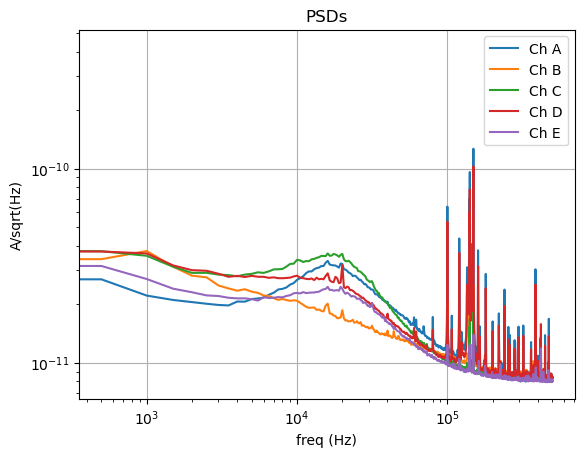

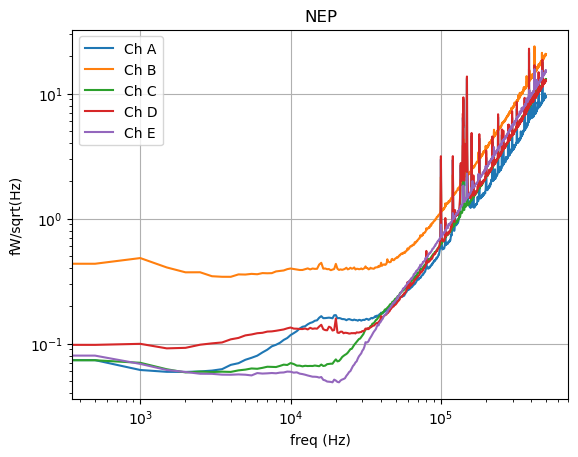

In [455]:
# calculate NEP from PSD data and write to txt files

psd_data_output_dir = folder_base + 'B13_Runs_LabVIEW/Run94/'

def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = np.loadtxt(filename)
    fs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return fs, psd

fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')


dpdi = {}

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(fs, didvfit[chan][3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(fs, psd, label = f'Ch {chan}')
    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')


ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



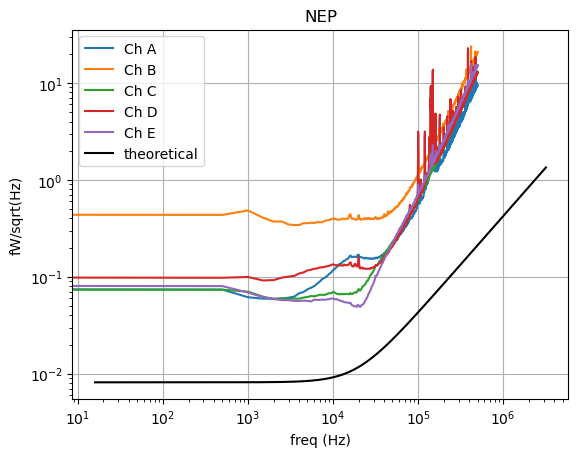

In [456]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in channels:
    fs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(fs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [457]:
dpdi['A'].shape, psd.shape

((1000,), (1000,))

In [458]:
# np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

In [459]:
# get pulse templates

templates_unnorm = {}
templates = {}

for c in channels:

    templates_unnorm[c] = np.loadtxt(psd_path + f'Templates 2/Ch {c} Template.txt')

    templates[c] = templates_unnorm[c]/templates_unnorm[c].max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates['A'].size, 1e-3) # templates = 2 ms traces

sampling_freq = templates['A'].size/2e-3 # Hz

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

In [460]:
if 0:
    # butterworth filter at 50 kHz
    filter_order = 10
    filter_freq = 5e4 # Hz
    butt = sg.butter(N = filter_order, Wn = filter_freq, btype = 'lowpass', output = 'sos', fs = sampling_freq)

    for c in channels:
        templates[c] = sg.sosfilt(butt, templates[c])
        templates[c] /= templates[c].max()

Text(0.5, 0, 'time (ms)')

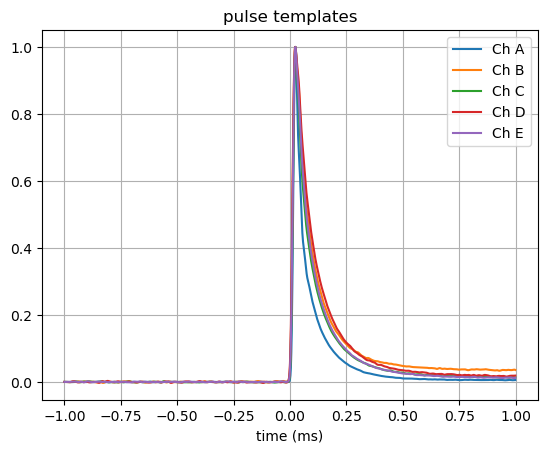

In [461]:
plt.figure()

for c in channels:
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

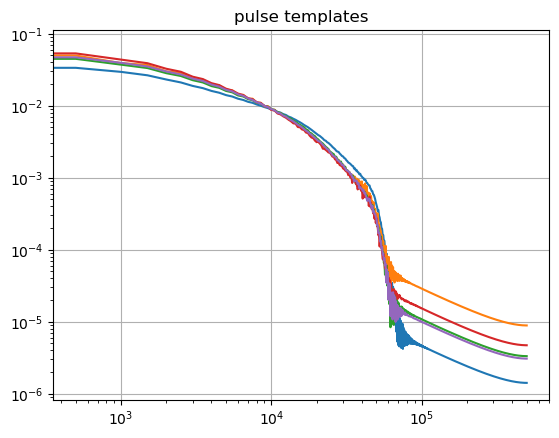

In [462]:
plt.figure()

for c in channels:
    plt.plot(fs, abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [463]:
# convert templates to frequency domain and convert to power
pulse_power = {}

template_energy = {} # energy (keV) of template

edge_cut = 5

for c in channels:

    temp_w = of.fft(templates[c]) # template current frequencies

    #dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))

    pow_w = temp_w*dpdi_unfolded # template power frequencies

    pulse_power[c] = of.ifft(pow_w) # template power

    template_energy[c] = np.trapz(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / 1.602e-16 # energy of unit-height template in keV
    

Text(0.5, 0, 'time (ms)')

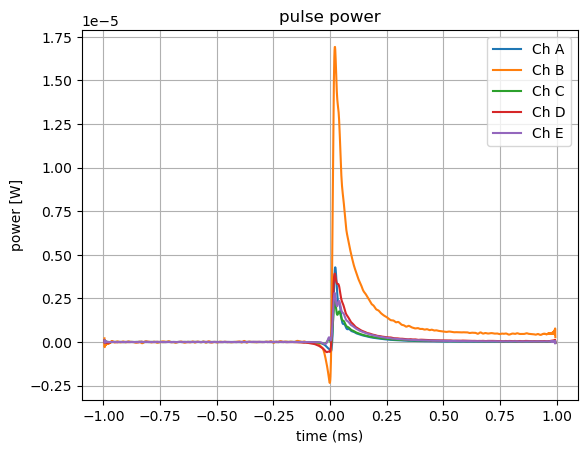

In [464]:
plt.figure()

for c in channels:
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [465]:
template_energy

{'A': 1276662.5619871253,
 'B': 10388206.37281171,
 'C': 1291317.8276361946,
 'D': 2039833.7242827078,
 'E': 1741384.6017310545}

In [466]:
resolutions = {}
resolutions2 = {}

print('energy resolutions (2 estimation methods)')

for c in channels:

    fs, psd = read_PSD(psd_path + f'PSD/Ch {c} PSD.txt', nsamples = 1000_000, trace_length = 1) # Hz, A/sqrt(Hz)

    nep = (abs(psd)*abs(dpdi[c]))**2 # W^2/Hz
    Jn = abs(psd)**2 # A^2/Hz

    resolutions[c] = of.resolution(templates[c]/templates[c].max(), np.hstack((Jn, Jn[::-1]))/2, 1.)*template_energy[c] # keV

    #resolutions2[c] = of.resolution(np.real(pulse_power[c])/np.real(pulse_power[c]).max(), np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c]/np.real(pulse_power[c]).max() # of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)
    resolutions2[c] = of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c] # keV

    print(f'{c}: {1e3*resolutions[c]:.5g} eV, {1e3*resolutions2[c]:.5g} eV')

    if 0:#c == 'E':
        sn = of.fft(templates[c]/templates[c].max())
        J1 = np.hstack((Jn, Jn[::-1]))/2
        sn2 = of.fft(pulse_power[c]/pulse_power[c].max())
        J2 = np.hstack((nep, nep[::-1]))/2
        plt.figure(figsize = (4,3))
        plt.grid()
        plt.title(c)
        a = np.sqrt(abs(sn)**2/J1)/template_energy[c]
        b = np.sqrt(abs(sn2)**2/J2)*1.6e-16
        plt.plot(a)
        plt.plot(b)
        plt.loglog()
        ratio = a/b
        print(f'ratio: {ratio.mean():.6g} +/- {ratio.std():.6g}')

energy resolutions (2 estimation methods)
A: 0.12586 eV, 0.12586 eV
B: 0.96084 eV, 0.96084 eV
C: 0.15139 eV, 0.15139 eV
D: 0.21058 eV, 0.21058 eV
E: 0.14979 eV, 0.14979 eV


In [467]:
# calculate phonon collection efficiency

print('phonon collection efficiencies')
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

phonon collection efficiencies
C : 0.083202 %
D : 0.13143 %
E : 0.1122 %


Text(0.5, 0, 'time (ms)')

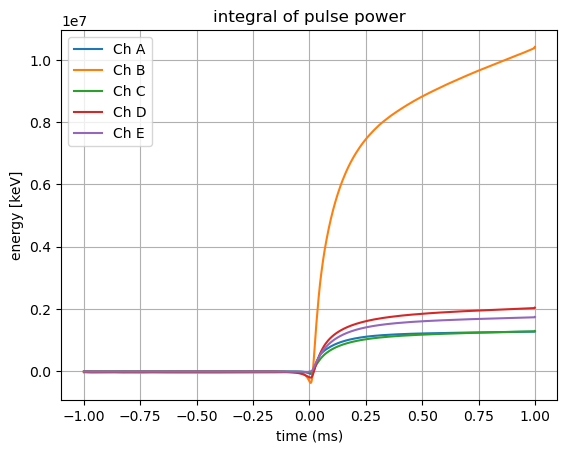

In [468]:
# cumulative energy
plt.figure()

for c in channels:
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')